In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.neighbors import KernelDensity

from gpflow.kernels import SquaredExponential, ArcCosine
from gpflow.likelihoods import Bernoulli
from gpflow.models import SVGP
from gpflow.optimizers import Scipy
from gpflow.utilities import set_trainable

In [2]:
# Data
X, Y = make_moons(n_samples=100, noise=0.2, random_state=0)
Y = Y[:, None].astype('float64')

# Plotting defaults
mask = Y[:, 0] == 1
x_grid = np.linspace(-3, 3.5, 120)
extent = [x_grid.min(), x_grid.max(), x_grid.min(), x_grid.max()]
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T


# Inductive Biases, Input Densities, and Predictive Uncertainty
Mark van der Wilk, October 2021

Related to my talk at [GenU 2021](genu.ai/2021) ([slides](https://mvdw.uk/talk/input-densities-and-predictive-uncertainties/)).

Questions:
- What is good behaviour of predictive error bars?
  - Should we be uncertain "far away" from the training data?
- Can we use input density as a metric for predictive uncertainty?
- How should we measure uncertainty we get from models?

Perhaps current predictive metrics on test sets are too simplistic to properly measure quality of
uncertainty?

## Gold-standard Gaussian processes
Gaussian processes are often considered the "gold standard" model for uncertainty estimation. Often
in Bayesian Deep Learning, the aim is to replicate Gaussian process properties in Deep Neural
Networks.

What worries me, is that it seems that the properties that are targeted, are often those of a GP
with a _Squared Exponential_ kernel.

In [3]:
m_sqexp = SVGP(SquaredExponential(), Bernoulli(), X[:, :])
set_trainable(m_sqexp.inducing_variable, False)
Scipy().minimize(m_sqexp.training_loss_closure((X, Y), compile=True), m_sqexp.trainable_variables);

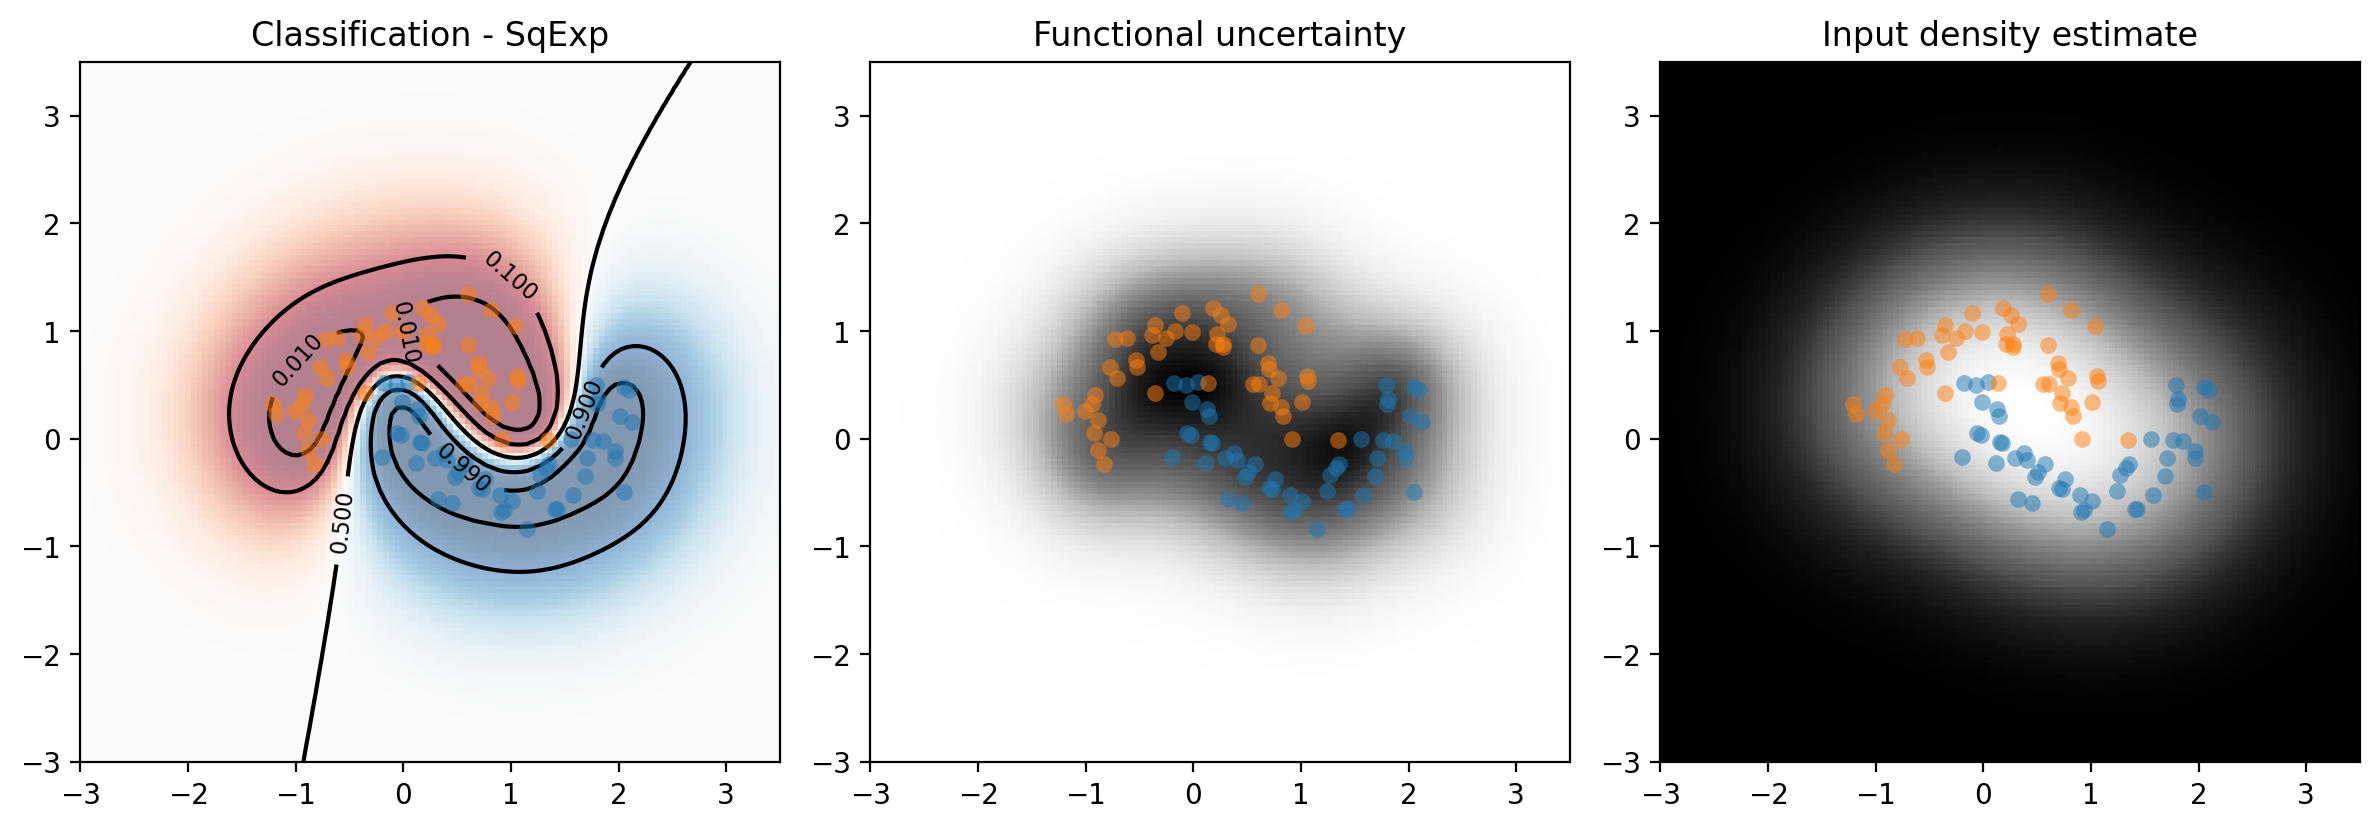

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
p, _ = m_sqexp.predict_y(Xplot)  # here we only care about the mean
_, fv = m_sqexp.predict_f(Xplot)
fv = fv ** 0.5

ax1.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax1.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
ax1.imshow(p.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='RdBu', alpha=0.5)
contours = ax1.contour(xx, yy, p.numpy().reshape(*xx.shape), [0.01, 0.1, 0.5, 0.9, 0.99], colors='black')
ax1.clabel(contours, inline=True, fontsize=8)
ax1.set_title("Classification - SqExp")

ax2.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax2.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
im = ax2.imshow(fv.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='Greys_r')
ax2.set_title("Functional uncertainty")

kde = KernelDensity(kernel='gaussian', bandwidth=m_sqexp.kernel.lengthscales.numpy()).fit(X)
X_kde = np.exp(kde.score_samples(Xplot))
ax3.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax3.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
ax3.imshow(X_kde.reshape(*xx.shape), extent=extent, origin='lower', cmap='Greys_r')
ax3.set_title("Input density estimate")

plt.tight_layout()
fig.savefig("./figures/classification-halfmoon-sqexp.png")

Conclusions drawn from this example:
- We want large uncertainty far from the data.
- Converse: We want large uncertainty where data density is low.
  - Could we use a density model $p(x)$ instead of trying to do Bayesian inference? We're quite
    good at generative models these days..!

But, is this always the right behaviour?

## Pathological behaviour?
On this toy problem, neural networks often behave a bit as below.

In [5]:
m_arccos = SVGP(ArcCosine(order=2), Bernoulli(), X[:, :])
set_trainable(m_arccos.inducing_variable, False)
Scipy().minimize(m_arccos.training_loss_closure((X, Y), compile=True), m_arccos.trainable_variables);

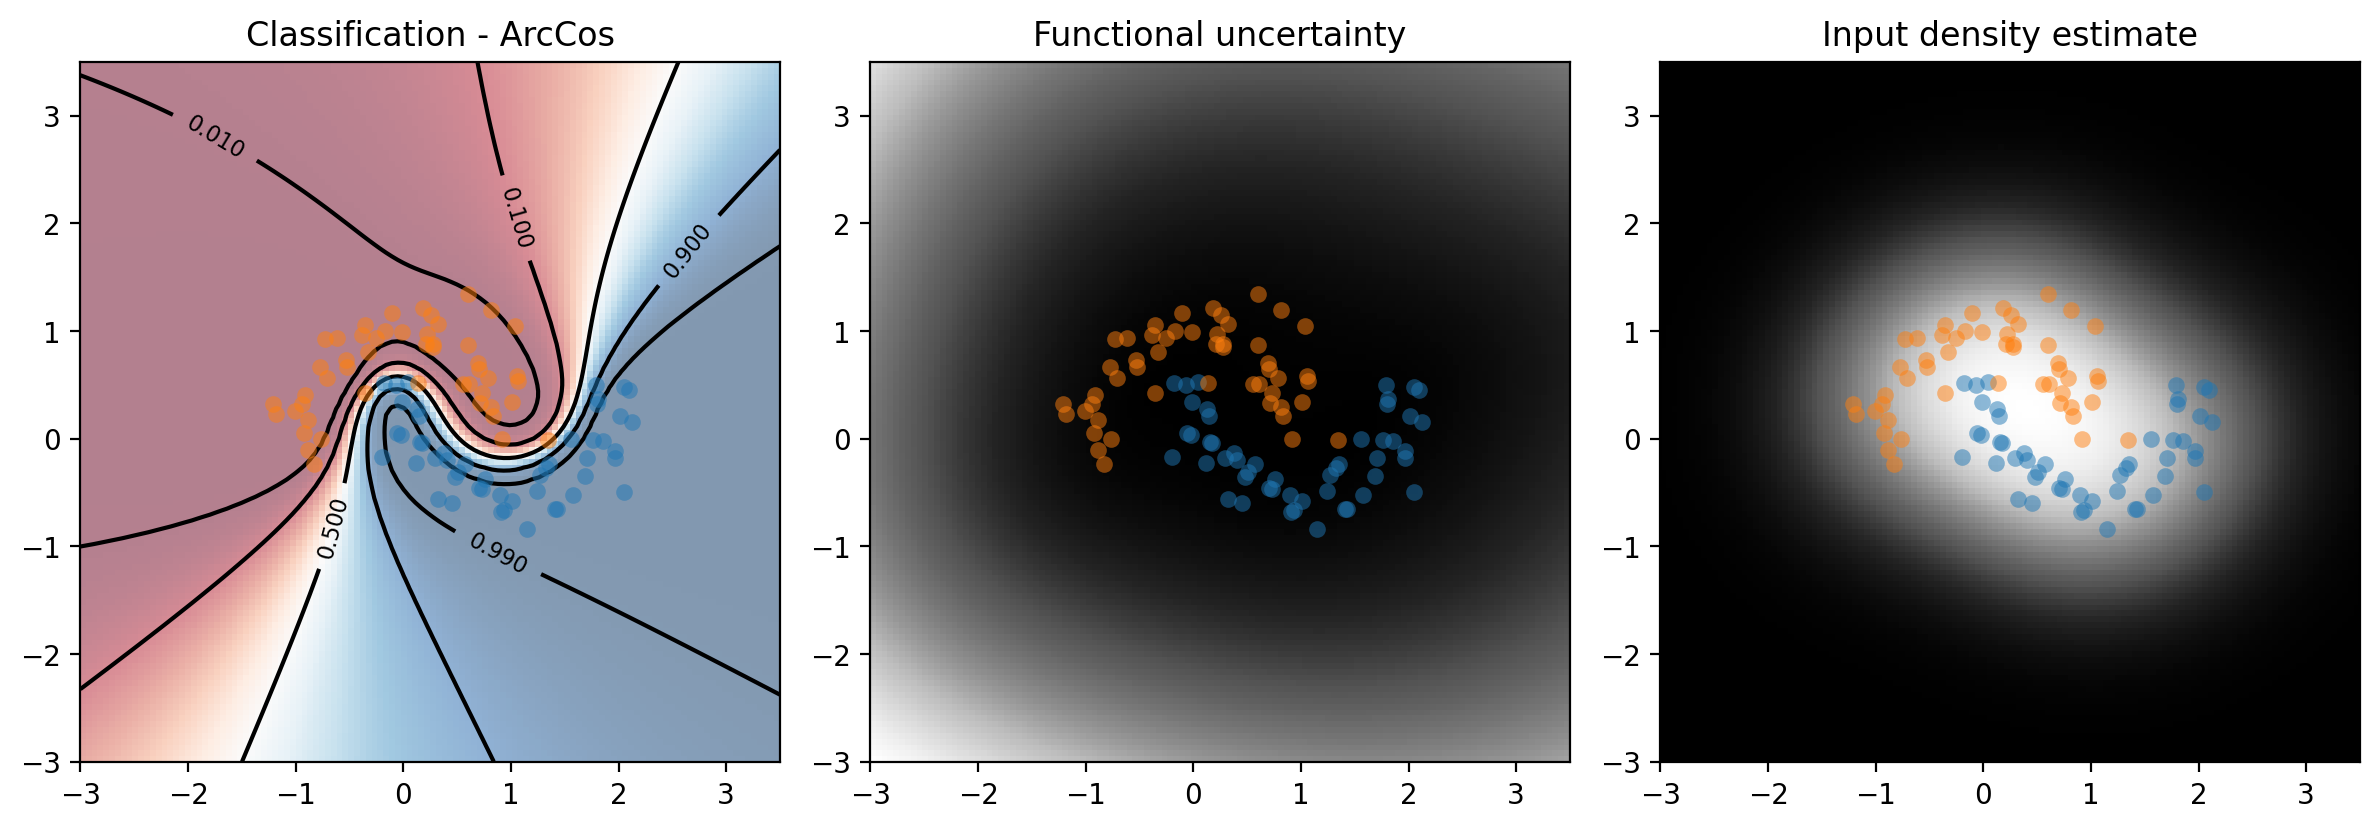

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
p, _ = m_arccos.predict_y(Xplot)  # here we only care about the mean
_, fv = m_arccos.predict_f(Xplot)
fv = fv ** 0.5

ax1.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax1.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
ax1.imshow(p.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='RdBu', alpha=0.5)
contours = ax1.contour(xx, yy, p.numpy().reshape(*xx.shape), [0.01, 0.1, 0.5, 0.9, 0.99], colors='black')
ax1.clabel(contours, inline=True, fontsize=8)
ax1.set_title("Classification - ArcCos")

ax2.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax2.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
im = ax2.imshow(fv.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='Greys_r')
ax2.set_title("Functional uncertainty")

kde = KernelDensity(kernel='gaussian', bandwidth=m_sqexp.kernel.lengthscales.numpy()).fit(X)
X_kde = np.exp(kde.score_samples(Xplot))
ax3.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax3.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
ax3.imshow(X_kde.reshape(*xx.shape), extent=extent, origin='lower', cmap='Greys_r')
ax3.set_title("Input density estimate")

plt.tight_layout()
fig.savefig("./figures/classification-halfmoon-arccos.png")


Is this poor behaviour? This is actually also a GP, just with a different _inductive bias_.
Interestingly, the latter model is obtained by taking the infinite limit of a ReLU network, so
perhaps it's not surprising that NNs extrapolate like this!

So which one is right, and which one is wrong? Which behaviour should we try to replicate in
Bayesian neural networks? **It's hard to tell** what the right behaviour is. Both seem reasonable
on this dataset?

The SqExp model assumes that the function can change anywhere, and therefore becomes uncertain quickly.
The ArcCos model seems to make an assumption that the trend of the same class being on the same
side of the decision boundary will continue. In some ways the SqExp model is too pessimistic.
There does seem to be a trend, why not take some risk for the reward of making a correct
extrapolation? However, the strength with which the ArcCos model extrapolates does seem risky.


## Which model is "right"?
Bayesian model selection through maximising the marginal likelihood is one way to figure out which
model to use. Let's see what it suggests.

In [7]:
kern_arccos = ArcCosine(order=2)
m = SVGP(kern_arccos + SquaredExponential(), Bernoulli(), X[:, :])
set_trainable(m.inducing_variable, False)
Scipy().minimize(m.training_loss_closure((X, Y), compile=True), m.trainable_variables);

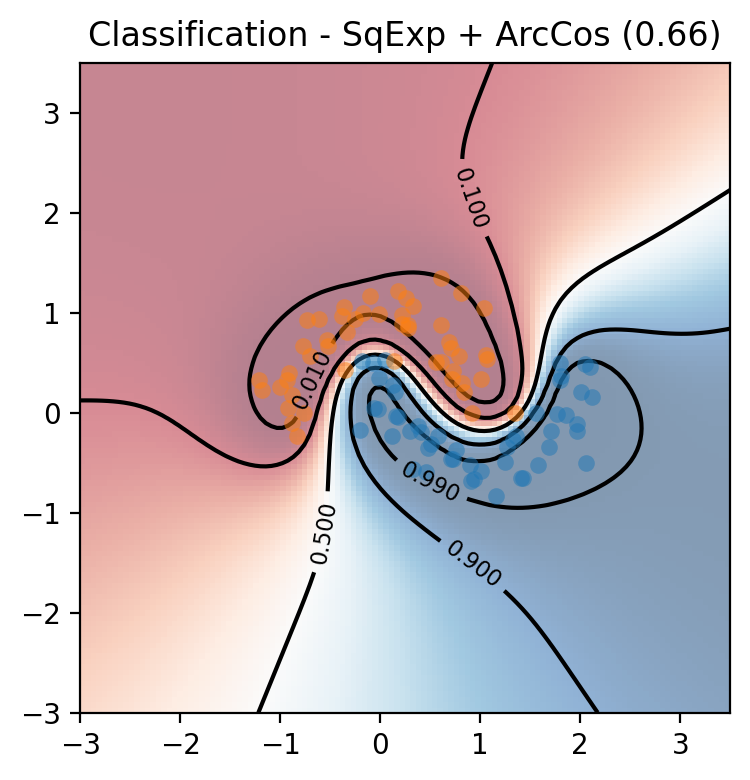

In [8]:
p, _ = m.predict_y(Xplot)  # here we only care about the mean
_, fv = m.predict_f(Xplot)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
ax.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
ax.imshow(p.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='RdBu', alpha=0.5)

contours = ax.contour(xx, yy, p.numpy().reshape(*xx.shape), [0.01, 0.1, 0.5, 0.9, 0.99], colors='black')
ax.clabel(contours, inline=True, fontsize=8)
ax.set_title(f"Classification - SqExp + ArcCos ({m.kernel.kernels[0].variance.numpy() ** 0.5:.2f})")

plt.tight_layout()
fig.savefig("./figures/classification-halfmoon-sumkern.png")

We obtain a solution that has an appreciable component of the ArcCosine kernel, causing it to have
some (but not all!) of the strong extrapolation behaviour of the pure ArcCosine kernel. Ths looks
really dangerous! What happens if the problem doesn't extrapolate in that way?

Let's see how the model behaves in a problem where it shouldn't extrapolate. We give a single
datapoint in the top left corner, with the opposite label.

In [9]:
Xa = np.vstack((X, [-2.5, 3.0]))
Ya = np.vstack((Y, 1))
m = SVGP(ArcCosine(order=2) + SquaredExponential(), Bernoulli(), Xa[:, :])
set_trainable(m.inducing_variable, False)
Scipy().minimize(m.training_loss_closure((Xa, Ya), compile=True), m.trainable_variables);

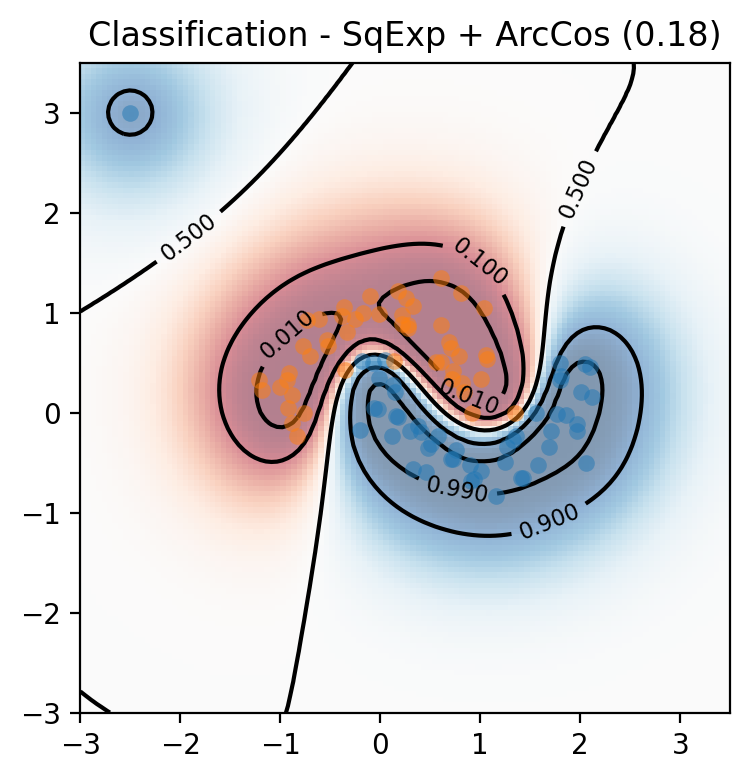

In [10]:
p, _ = m.predict_y(Xplot)  # here we only care about the mean
_, fv = m.predict_f(Xplot)

maska = Ya[:, 0] == 1
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.plot(Xa[maska, 0], Xa[maska, 1], "oC0", mew=0, alpha=0.5)
ax.plot(Xa[np.logical_not(maska), 0], Xa[np.logical_not(maska), 1], "oC1", mew=0, alpha=0.5)
ax.imshow(p.numpy().reshape(*xx.shape), extent=extent, origin='lower', cmap='RdBu', alpha=0.5)

contours = ax.contour(xx, yy, p.numpy().reshape(*xx.shape), [0.01, 0.1, 0.5, 0.9, 0.99], colors='black')
ax.clabel(contours, inline=True, fontsize=8)
ax.set_title(f"Classification - SqExp + ArcCos ({m.kernel.kernels[0].variance.numpy() ** 0.5:.2f})")

plt.tight_layout()
fig.savefig("./figures/classification-halfmoon-sumkern-adapted.png")

We see that a *single* datapoint is enough to completely change the extrapolation behaviour of the
model. Even though the extrapolation behaviour that we saw earlier may lead us to conclude that the
wrong model was chosen, if we consider a continual learning setting, then the behaviour may seem a lot
more reasonable: Extrapolate strongly and risk incurring a loss once, and if you're wrong, back off
and be a lot more cautious.

## Take-homes
- There is a trade-off between generalisation and extrapolation (which can be desirable!) and
  having high uncertainty.
- Evaluating uncertainty on a test set may overly-harsly penalise models, as the setting does not
  allow them to adapt based on new data. Maybe we should all be doing continual learning?

## Todo...
- Invariance example https://twitter.com/markvanderwilk/status/1184235600414683136
- You can't complete the pattern while also remaining uncertain far from the data!
- When is there a large difference between the marginal likelihood and crossvalidation?